## Import packages

In [1]:
import numpy as np
import pandas as pd
import pygimli as pg
from pygimli.physics import ert
import matplotlib.pyplot as plt
import math
import sys


## Data processing function:

In [2]:

def process_ERT_data(data_raw,survey_name,plotdata,plotmodel,plotmisfit):

    # calculate geometric factor and apparent resistivity if not already in data file

    if data_raw.haveData('k')==False:
        if max(np.array(data.sensors()).T[2])-min(np.array(data.sensors()).T[2])==0: # is it flat?
            data_raw['k'] = ert.createGeometricFactors(data_raw) # no need for numerical solution
        else: # topography?
            data_raw['k'] = ert.createGeometricFactors(data_raw,numerical=True) # include topo in k calculation
            
    if data_raw.haveData('rhoa')==False:
        if data_raw.haveData('r')==False:
            data_raw['r'] = data_raw['u']/data_raw['i']
        data_raw['rhoa'] = data_raw['r']*data_raw['k'] 


    # put data into pandas dataframe

    df = pd.DataFrame(np.array(data_raw.dataMap(),dtype='object').T)
    header = df.iloc[0]
    df = df[1:] 
    df.columns = header
    df = df.apply(pd.Series.explode).reset_index(drop=True)

    df_raw = pd.DataFrame(df)
    df_raw['start_index'] = df_raw.index

    # look for reciprocal or repeated measurements

    src = np.stack([df_raw['a'],df_raw['b']]).T
    rec = np.stack([df_raw['m'],df_raw['n']]).T

    src_f = src[0]
    rec_f = rec[0]
    ind_f = [0]
    ind_r = []
    reps = []
    recips = []

    for i in range(1,len(src)): 

        if len(rec_f)==2:
            a = np.where(np.all(rec_f==src[i],axis=0))[0] # reciprocals
            b = np.where(np.all(src_f==rec[i],axis=0))[0]

            c = np.where(np.all(src_f==src[i],axis=0))[0] # repeated
            d = np.where(np.all(rec_f==rec[i],axis=0))[0]
        else:
            a = np.where(np.all(rec_f==src[i],axis=1))[0] # reciprocals
            b = np.where(np.all(src_f==rec[i],axis=1))[0]

            c = np.where(np.all(src_f==src[i],axis=1))[0] # repeated
            d = np.where(np.all(rec_f==rec[i],axis=1))[0]   

        ind_recip = np.intersect1d(a,b)
        ind_rep = np.intersect1d(c,d)

        if len(ind_recip)>0:
            ind_r.append(i)
            recips.append(ind_recip)

        elif len(ind_rep)>0:
            ind_r.append(i)
            reps.append(ind_rep)

        else:
            src_f = np.vstack((src_f,[src[i]]))
            rec_f = np.vstack((rec_f,[rec[i]]))
            ind_f.append(i)

    recips = np.squeeze(recips) 
    reps = np.squeeze(reps)

    # treat repeated and reciprocal measurements the same
    r_all = np.hstack([reps,recips]).astype(int)

    # if present, calculate new apparent resistivities and error vals

    df_f = df_raw.loc[ind_f]
    df_f = df_f.reset_index(drop=True)

    df_r = df_raw.loc[ind_r]
    df_r = df_r.reset_index(drop=True)

    df_checked = df_f.copy()
    df_checked['rep/recip'] = 0

    if len(ind_r)>0: #TODO this only handles recips now

        for i in range(len(ind_r)): # for all reciprocal measurements

            r_mean = (df_f.iloc[r_all[i]]['r'] + df_r.iloc[i]['r'])/2 
            r_err = (np.abs(df_f.iloc[r_all[i]]['r'] - df_r.iloc[i]['r'])/abs(r_mean))*100    
            df_checked.at[r_all[i],'r'] = r_mean
            df_checked.at[r_all[i],'rhoa'] = r_mean*df_r.iloc[i]['k']
            df_checked.at[r_all[i],'err'] = r_err
            df_checked.at[r_all[i],'rep/recip'] = 1


    # put everything back into the pygimli data container to plot
    data_checked = pg.DataContainerERT()

    # sensors are the same
    for i in range(0,len(data_raw.sensors())):
        data_checked.createSensor(np.array(data_raw.sensors()[i])) # 2D, no topography

    # add filtered quadripoles and data 

    cols = df_checked.columns
    for i in range(len(cols)):
        if max(df_checked[cols[i]]) > 0:
            data_checked[cols[i]] = np.array(df_checked[cols[i]])


    mgr = ert.ERTManager(data_checked)

    df_filt = df_checked.copy()

    I_tf = (np.unique(np.hstack([ 
        np.where(df_filt['rhoa'] <= 0)[0],
        np.where(df_filt['err'] > 10)[0],
        np.where(df_filt['rhoa'] > 9*np.std(df_filt['rhoa']))[0]
    ])))

    df_filt = df_filt.drop(I_tf)
    n_tf = len(I_tf)






    # to apply a moving median filter we will need to sort our data by depth level and array midpoint. 

    # find midpoint of array

    mp = np.mean([df_filt['a'],df_filt['b'],df_filt['m'],df_filt['n']],axis=0)

    # sort by depth level and midpoint so we can apply moving median filter
    # note: this works for 2D lines with topography and even electrode spacing

    # to find unique depth levels, check to find unique relative positions of electrodes

    ab = df_filt['a'] - df_filt['b']
    am = df_filt['a'] - df_filt['m']
    an = df_filt['a'] - df_filt['n']

    # pos is just a placeholder variable describing relative electrode positions...

    pos = (np.array([ab,am,an]).T).astype(dtype=float)
    pos_uniq = np.unique(pos, axis=0)

    # ...and we'll add this info to dataframe for convenience

    pos_i = []
    for i in range(len(pos)):
        pos_i.append(np.where((pos[i]==pos_uniq).all(axis=1))[0][0])

    df_filt['pos'] = pos_i

    # sort by depth level

    sort_index = np.argsort(pos)
    i_all = np.linspace(0,len(pos),len(pos)+1).astype('int')
    sort_index = np.array([])

    # sort by midpoint

    for i in range(len(pos_uniq)):
        j = np.where((pos==pos_uniq[i]).all(axis=1))
        si = np.argsort(mp[j])
        sort_index = np.append(sort_index,i_all[j][si]) 

    sort_index = sort_index.astype('int')

    # make a dataframe with sorted values


    df_sort = pd.DataFrame(columns = df_filt.columns,index=range(len(df_filt)))
    for i in range(len(df_filt)):
        df_sort.iloc[i] = df_filt.iloc[sort_index[i]]
    df_sort = df_sort.reset_index(drop=True)








    df_filt = df_sort.copy()

    th = 0.5 # threshold for filter TODO: make this higher for shallower data
    n_mmf = 0 # keeping track of how many data are removed

    ikeep = np.ones(df_filt.shape[0],dtype=bool)

    k=0

    for j in range(len(pos_uniq)): # loop through each unique depth level
        I = (np.where(df_filt['pos']==k)[0])

        # moving median of data points

        mm = [] 
        r = np.array(df_filt['rhoa'],dtype=float)[I]

        for i in range(len(I)): # loop through depth level from left to right
            if i==0:
                mm.append(np.median(r[i:3])) # end points only use two neighboring data points to calculate median
            elif i==1:
                mm.append(np.median(r[i-1:4])) 
            elif i==len(r)-2:
                mm.append(np.median(r[i-2:])) 
            elif i==len(r)-1:
                mm.append(np.median(r[i-2:])) 
            else:
                mm.append(np.median(r[i-2:i+3])) 

        ithrow = np.where(abs(r-mm)/mm > th)[0]
        n_mmf = n_mmf + len(ithrow)

        # get rid of outlier data 

        for i in range(len(ithrow)):
            ikeep[I[ithrow[i]]] = 0

        k=k+1     

    I_mmf = (df_filt[ikeep==False])['start_index']
    df_filt = df_filt[ikeep]
    df_filt = df_filt.reset_index(drop=True)



    # find the indices of all the points we removed
    I_all = np.hstack([I_tf,I_mmf])

    # how many times was each electrode used in the full dataset?
    [elec_all,count_all] = np.unique(np.hstack([df_raw['a'],df_raw['b'],df_raw['m'],df_raw['n']]), return_counts=True)

    # how many times was each electrode used in the data that got removed?
    df_removed = df_raw[df_raw['start_index'].isin(I_all)]
    [elec_removed,count_removed] = np.unique(np.hstack([df_removed['a'],df_removed['b'],df_removed['m'],df_removed['n']]), return_counts=True)

    # loop through and, for each electrode, calculate what percentage of data points were removed
    perc_filt = []
    for i in range(len(elec_all)):
        if elec_all[i] in elec_removed:
            I = np.where(elec_removed == elec_all[i])
            perc_filt.append(count_removed[I]/count_all[i]*100)

        else:
            perc_filt.append([0])

    perc_filt = np.hstack(perc_filt)

    # identify which electrodes are bad based on a threshold 
    # (here, if more than 25% of data with that electrode have been filtered)
    e_bad = elec_all[perc_filt > 25]
    
    if len(e_bad)==len(data_raw.sensors()):
        print('ABORT: too many data points filtered from %s. Data not inverted.'%filename)
        return (None,None)
        sys.exit()

    
    I_ef = []
    for i in range(len(df_filt['a'])):
        if (df_filt['a'].iloc[i] in e_bad) or (df_filt['b'].iloc[i] in e_bad) or (df_filt['m'].iloc[i] in e_bad) or (df_filt['n'].iloc[i] in e_bad):
            I_ef.append(True)
        else:
            I_ef.append(False)

    df_elec_filt = df_filt.drop(index = np.where(I_ef)[0])
    n_ef = len(e_bad)







    # put everything back into the pygimli data container

    data_filt = pg.DataContainerERT()

    # sensors are the same

    for i in range(0,len(data_raw.sensors())):
        data_filt.createSensor(np.array(data_raw.sensors()[i])) # 2D, no topography

    # add filtered quadripoles and data 

    cols = df_filt.columns
    for i in range(len(cols)):
        if max(df_elec_filt[cols[i]]) > 0:
            data_filt[cols[i]] = np.array(df_elec_filt[cols[i]])

            


    # put everything back into the pygimli data container

    data_filt = pg.DataContainerERT()

    # sensors are the same

    for i in range(0,len(data_raw.sensors())):
        data_filt.createSensor(np.array(data_raw.sensors()[i])) # 2D, no topography

    # add filtered quadripoles and data 

    cols = df_filt.columns
    for i in range(len(cols)):
        if max(df_elec_filt[cols[i]]) > 0:
            data_filt[cols[i]] = np.array(df_elec_filt[cols[i]])

    if (data_checked.size()-data_filt.size())/data_checked.size()*100>30:
        print('ABORT: too many data points filtered from %s. Data not inverted.'%filename)
        return (None,None)
        sys.exit()

        
        
            
            
    if plotdata==True:
        # plot filtered data

        fig, ax = plt.subplots(1,2,figsize=[20,5])

        mgr = ert.ERTManager(data_checked)
        mgr.showData(data_checked, vals=data_checked['rhoa'],ax=ax[0],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
        ax[0].set_title('Raw data',fontsize=24);

        mgr = ert.ERTManager(data_filt)
        mgr.showData(data_filt, vals=data_filt['rhoa'],ax=ax[1],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
        ax[1].set_title('Filtered data - %.0f data points removed (%.1f%% of the data)'%(data_checked.size()-data_filt.size(), float((data_checked.size()-data_filt.size())/data_checked.size()*100)),fontsize=24);

#         print('data points removed by technical filter = %.0f'%n_tf)
#         print('data points removed by moving median filter = %.0f'%n_mmf)
#         print('number of bad electrodes = %.0f'%n_ef)
#         print('data points removed by bad electrode filter = %.0f'%len(np.where(I_ef)[0]))
#         print('%.0f data points removed in total (%.1f%% of the data)'%(n_tf+n_mmf+n_ef, float((data_checked.size()-data_filt.size())/data_checked.size()*100)))
    

    
    
    if len (r_all)>0:

        fs=20

        I = np.where(df_filt['rep/recip']==1)
        x = abs(df_filt['r'].iloc[I])
        y = abs(df_filt['err'].iloc[I])*abs(df_filt['r'].iloc[I])/100 # absolute error

        nbins = 20
        ndata = len(I[0])
        npoints = math.ceil(ndata/nbins)

        df_filt = df_filt.sort_values(by=['r'],key=abs)
        xbin = []
        ybin = []
        for i in range(nbins):
            xbin.append(np.mean(x[i*npoints:(i+1)*npoints]))
            ybin.append(np.std(y[i*npoints:(i+1)*npoints]))

        p = np.polyfit(xbin,ybin, 1)

        if p[1]<0: # if absolute error is negative, just assign some small value
            p[1]=1e-3
        p[0] = p[0] + 0.02 # increase relative error by 2% to account for other sources of error

        print('error model: err = %.4f*|R|+%.4f'%(p[0],p[1]))

        # automated (from error model)
        data_filt['err'] = ert.estimateError(
        data_filt, 
        absoluteError=p[1], 
        relativeError=p[0] # % noise
        ) 

    else:

        data_filt['err'] = ert.estimateError(
        data_filt, 
        absoluteError=0.001, 
        relativeError=0.04 # % noise
        )


    # set whether lambda is being optimized by L-curve

    mgr.inv.inv.setOptimizeLambda(True)

    # use blocky model constraint

    mgr.inv.inv.setBlockyModel(True)

    # run inversion

    mod = mgr.invert(
        data_filt,
        verbose=False, 
    )

    # getting lambda, chi2, rms error

    lam = mgr.inv.inv.getLambda()
    chi2 = mgr.inv.inv.getChi2()
    rms = np.sqrt(np.mean(((data_filt['rhoa']-mgr.inv.response)/data_filt['rhoa'])**2))*100

    mesh = mgr.paraDomain.cellCenters()
#     mesh.save('/Users/teddiherringnew/Desktop/mesh')
#     mgr.model.save('/Users/teddiherringnew/Desktop/model')
#     np.savetxt('/Users/teddiherringnew/Desktop/coverage.vector', mgr.coverage())

    ert_inv = {
        'x_mid': np.reshape(mesh,[len(mgr.model),3]).T[0].tolist(),
        'z_mid': np.reshape(mesh,[len(mgr.model),3]).T[1].tolist(),
        'rho_s': np.array(mgr.model).tolist(),
        'sens': mgr.coverage().tolist(),
        'survey_name':[survey_name]*len(mgr.model),
        'rms':[rms]*len(mgr.model),
        
    }
    
    if plotmodel==True:
    
        fig, ax = plt.subplots(1,1,figsize=[15,5])

        ax, cBar = mgr.showResult(
           mod,
            ax=ax,
            cMap='turbo_r',
            coverage=mgr.coverage(),
            cMin=np.sort(mgr.paraModel())[int(len(mgr.paraModel())/100)], # this part trims the color scale to make things easier to see
            cMax=np.sort(mgr.paraModel())[-int(len(mgr.paraModel())/100)],

        );

        cBar.set_label(r'$\rho$ [$\Omega$m]')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Z (m)')
        ax.set_title(r'chi$^2$ = %.2f, rms error = %.2f%%'%(chi2,rms),fontsize=20);

    if plotmisfit==True:
        fig, ax = plt.subplots(1,3,figsize=[15,5])
        mgr.showData(data_filt, vals=data_filt['rhoa'],ax=ax[0],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
        mgr.showData(data_filt, vals=mgr.inv.response,ax=ax[1],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r',cMin=min(data_filt['rhoa']),cMax=max(data_filt['rhoa']));
        mgr.showData(data_filt, vals=((mgr.inv.response-data_filt['rhoa'])/data_filt['rhoa'])*100,ax=ax[2],label='Error (%)',cMap='seismic',cMin=-20,cMax=20);
        ax[0].set_title('Observed data (filtered)',fontsize=20)
        ax[1].set_title('Predicted data',fontsize=20)
        ax[2].set_title('Misfit',fontsize=20);

    return mgr, ert_inv


## Load the data

In [3]:
# load data (separated into electrodes and data file for convenience)

elecs = pd.read_csv('data_AERT/craterlake_electrodes.txt', sep='\t')
data_in = pd.read_csv('data_AERT/craterlake_data.txt',sep='\t')

# make dictionary to store results
n_data = 57
n_header = 3
n_lines = n_data + n_header
n_surveys = int(len(data_in)/(n_lines))

# get electrodes

# indices
A = (elecs['A'].to_numpy())
B = (elecs['B'].to_numpy())
M = (elecs['M'].to_numpy())
N = (elecs['N'].to_numpy())

E = np.linspace(0,9.5,20) # positions


## Test a subset of the data to see if things are working okay

25/04/22 - 18:20:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4293420630988484170
25/04/22 - 18:20:23 - pyGIMLi - INFO - Found 2 regions.
25/04/22 - 18:20:23 - pyGIMLi - INFO - Region with smallest marker (1) set to background
25/04/22 - 18:20:23 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
25/04/22 - 18:20:23 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
25/04/22 - 18:20:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
25/04/22 - 18:20:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
25/04/22 - 18:20:23 - pyGIMLi - INFO - Use median(data values)=31893.535013041554
25/04/22 - 18:20:23 - pyGIMLi - INFO - Created startmodel from forward operator: 295 [31893.535013041554,...,31893.535013041554]


25/04/22 - 18:20:24 - pyGIMLi - INFO - Save RVector binary
25/04/22 - 18:20:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/208623990376181202


ABORT: too many data points filtered from 22.06.2019 12:00:00. Data not inverted.


25/04/22 - 18:20:24 - pyGIMLi - INFO - Found 2 regions.
25/04/22 - 18:20:24 - pyGIMLi - INFO - Region with smallest marker (1) set to background
25/04/22 - 18:20:24 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
25/04/22 - 18:20:24 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
25/04/22 - 18:20:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
25/04/22 - 18:20:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
25/04/22 - 18:20:24 - pyGIMLi - INFO - Use median(data values)=417163.10351519944
25/04/22 - 18:20:24 - pyGIMLi - INFO - Created startmodel from forward operator: 295 [417163.10351519944,...,417163.10351519944]
25/04/22 - 18:20:25 - pyGIMLi - INFO - Save RVector binary
25/04/22 - 18:20:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8621906813747473469


25/04/22 - 18:20:26 - pyGIMLi - INFO - Found 2 regions.
25/04/22 - 18:20:26 - pyGIMLi - INFO - Region with smallest marker (1) set to background
25/04/22 - 18:20:26 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
25/04/22 - 18:20:26 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
25/04/22 - 18:20:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
25/04/22 - 18:20:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
25/04/22 - 18:20:26 - pyGIMLi - INFO - Use median(data values)=18717.696994682286
25/04/22 - 18:20:26 - pyGIMLi - INFO - Created startmodel from forward operator: 295 [18717.696994682286,...,18717.696994682286]
25/04/22 - 18:20:27 - pyGIMLi - INFO - Save RVector binary
25/04/22 - 18:20:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2845601146396637394
25/04/22 - 18:20:28 - pyGIMLi - INFO - Found 2 regions.
25/04/22 - 18:20:28 - pyGIML

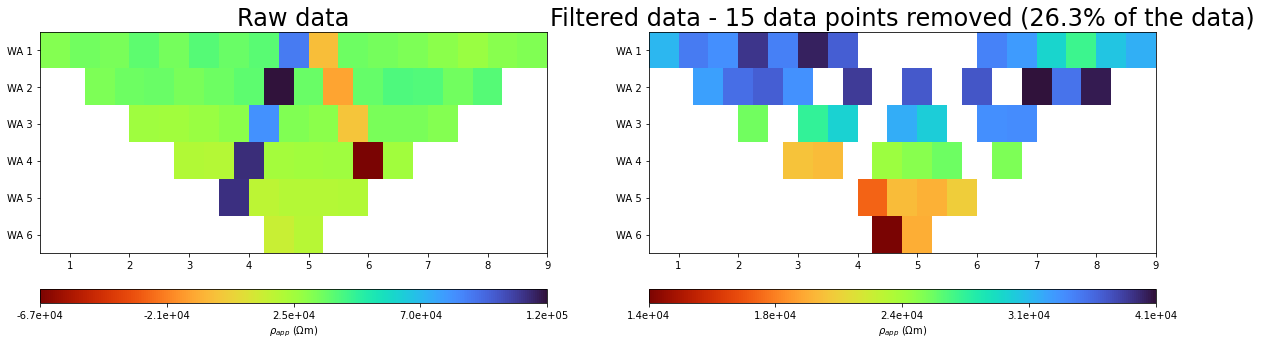

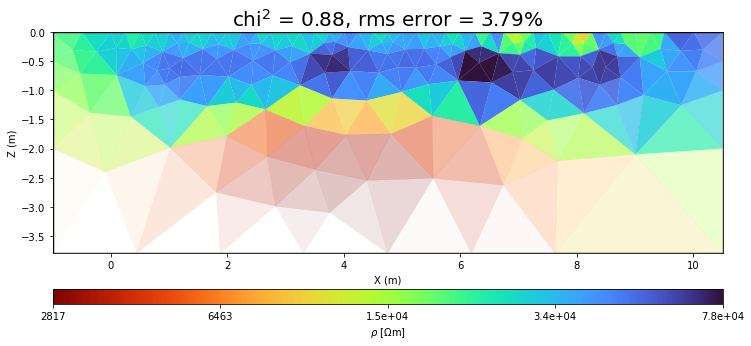

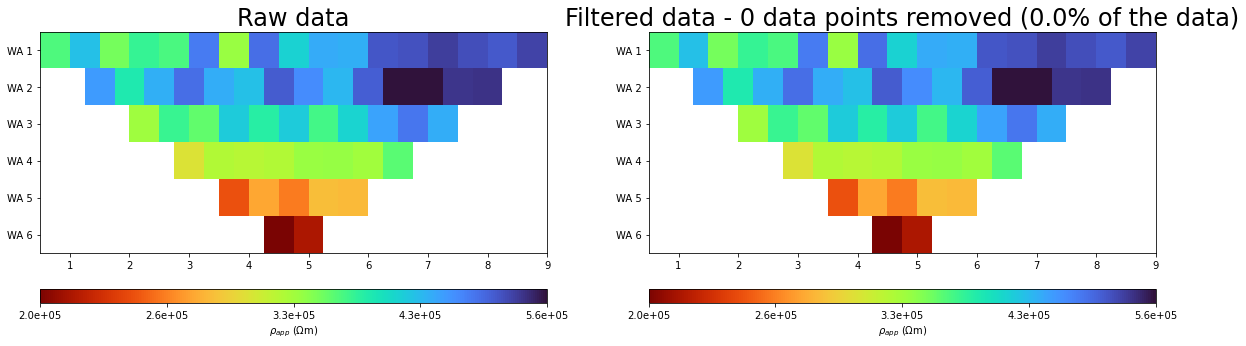

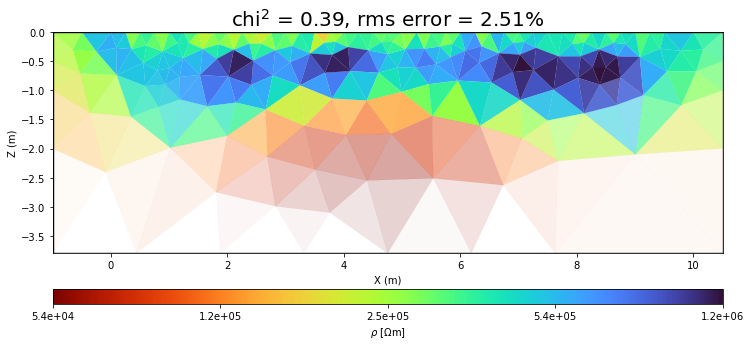

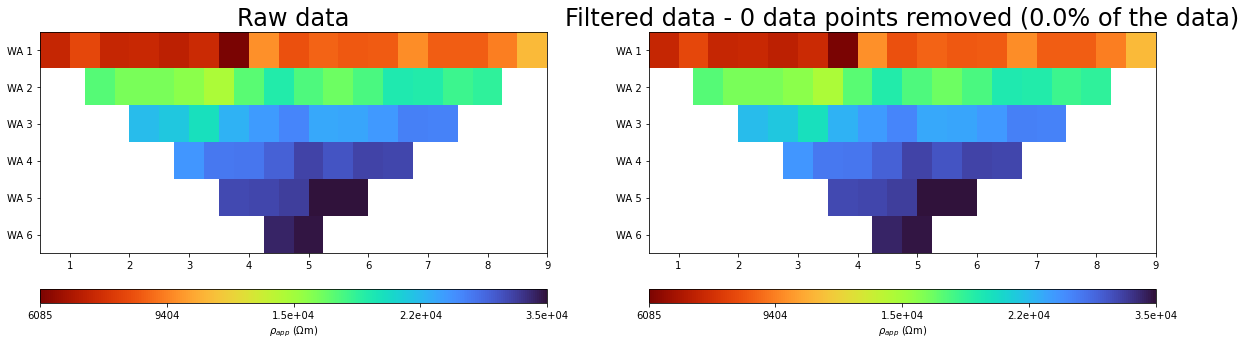

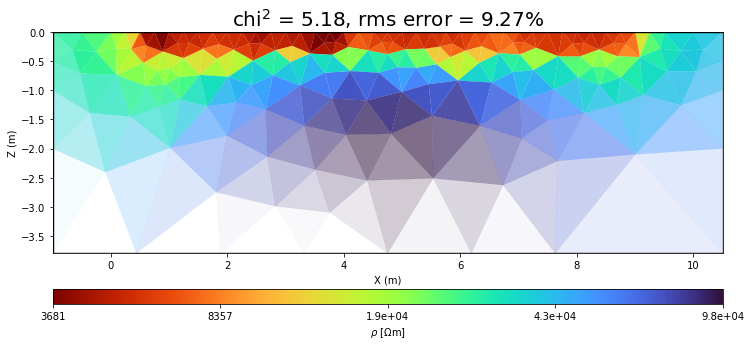

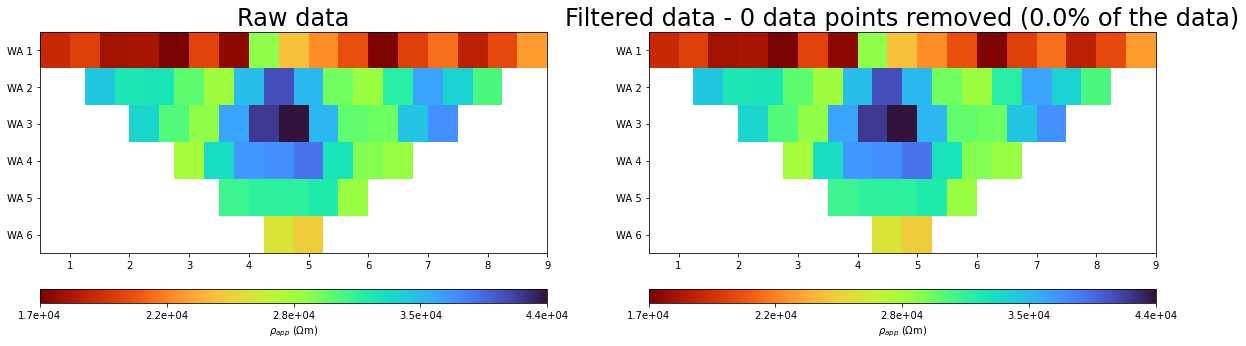

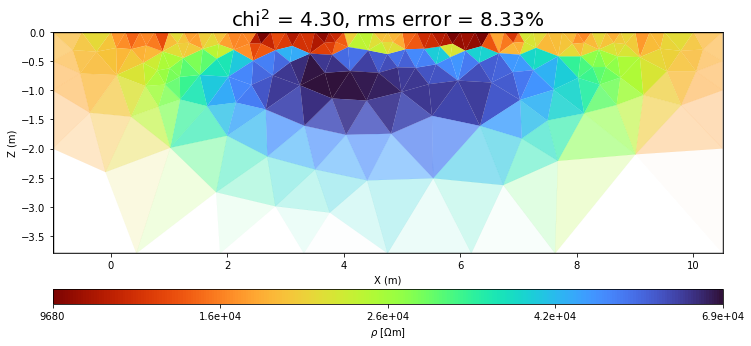

In [10]:
# choose some random datasets...

# import random

# n_tests = 5

# test_i = []
# for i in range(n_tests):
#     test_i.append(random.randint(0, n_surveys))
    
# test_i = np.sort(test_i)


# ... or test a couple specific datasets

test_i = [339,543,1000,1200,1400] 
# 339 has a few data points removed 
# 543 is where it crashed last time, due to too many data points removed


# make dictionary to store results

ert_all = dict.fromkeys(['x_mid','z_mid','rho_s','sens','survey_name','rms'])

for j in range(0,len(test_i)):

    data = pg.DataContainerERT()

    for i in range(0,len(E)):
        data.createSensor([E[i], 0.0]) # 2D, no topography

    cf = []
    for i in range(0,len(A)):
        cf.append([A[i]-1,B[i]-1,M[i]-1,N[i]-1])

    for i in range(0,len(A)):
        data.createFourPointData(i, *map(int, cf[i])) 

    i = test_i[j]    
    
    filename = data_in.iloc[i*n_lines]['U0(mV)'][0:10] + ' ' + data_in.iloc[i*n_lines]['U90(mV)'][0:8] # use date and time to ID surveys
    
    data['err'] = np.array(data_in['errorU0(%)'].iloc[(i*n_lines)+3:(i+1)*n_lines].astype(float))
    data['u'] = np.array(data_in['U0(mV)'].iloc[(i*n_lines)+3:(i+1)*n_lines].astype(float)/1000)
    data['i'] = np.array(data_in['I(mA)'].iloc[(i*n_lines)+3:(i+1)*n_lines].astype(float)/1000)
        
    mgr, ert_inv = process_ERT_data(
        data_raw = data,
        survey_name = filename,
        plotdata=True,
        plotmodel=True,
        plotmisfit=False)    

    if ert_inv == None:
        pass
    else:
        if ert_all['x_mid']==None:
            ert_all = ert_inv 
        else:
            ert_all = {key: ert_all[key] + ert_inv[key] for key in ert_all}


ert_all = pd.DataFrame.from_dict(ert_all)

## Run all inversions [WARNING: may take a long time, uncomment all to run]

In [ ]:

# # make dictionary to store results

# ert_all = dict.fromkeys(['x_mid','z_mid','rho_s','sens','survey_name','rms'])

# for j in range(0,n_surveys):

#     data = pg.DataContainerERT()

#     for i in range(0,len(E)):
#         data.createSensor([E[i], 0.0]) # 2D, no topography

#     cf = []
#     for i in range(0,len(A)):
#         cf.append([A[i]-1,B[i]-1,M[i]-1,N[i]-1])

#     for i in range(0,len(A)):
#         data.createFourPointData(i, *map(int, cf[i])) 

#     i = rand_i[j]    
    
#     filename = data_in.iloc[i*n_lines]['U0(mV)'][0:10] + ' ' + data_in.iloc[i*n_lines]['U90(mV)'][0:8] # use date and time to ID surveys
    
#     data['err'] = np.array(data_in['errorU0(%)'].iloc[(i*n_lines)+3:(i+1)*n_lines].astype(float))
#     data['u'] = np.array(data_in['U0(mV)'].iloc[(i*n_lines)+3:(i+1)*n_lines].astype(float)/1000)
#     data['i'] = np.array(data_in['I(mA)'].iloc[(i*n_lines)+3:(i+1)*n_lines].astype(float)/1000)
        
#     ert_inv = process_ERT_data(
#         data_raw = data,
#         survey_name = filename,
#         plotdata=True,
#         plotmodel=True,
#         plotmisfit=False)    

#     if ert_all['x_mid']==None:
#         ert_all = ert_inv 
#     else:
#         ert_all = {key: ert_all[key] + ert_inv[key] for key in ert_all}


# ert_all = pd.DataFrame.from_dict(ert_all)

## Save results locally

In [11]:
ert_all.to_csv('ert_all')
mgr.paraDomain.exportVTK('mesh')

## Load and plot results 

In [12]:
mesh = pg.load('mesh.vtk')
ert_all = pd.read_csv('ert_all', sep=',',index_col=0)

n_surveys_proc = len(np.unique(ert_all['survey_name']))

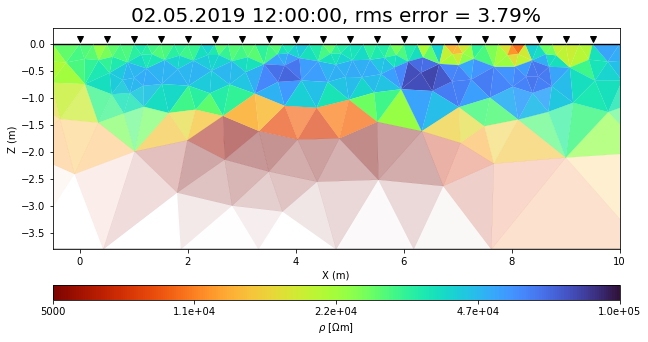

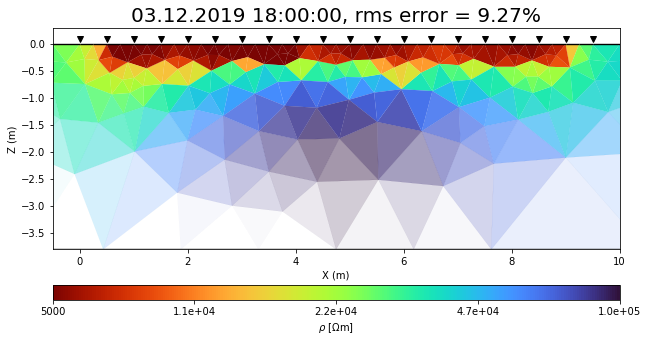

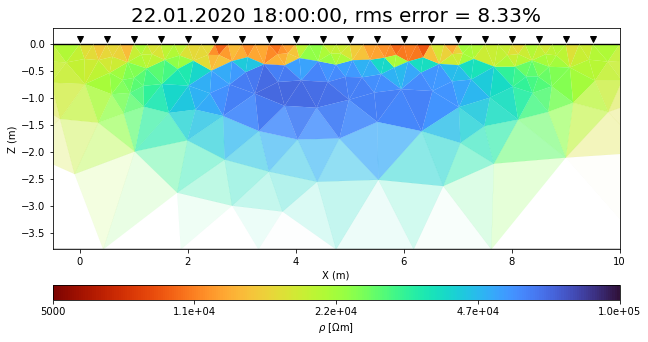

In [13]:
# you'll probably want to select a subset of data to plot.
# here, you can choose to plot n surveys and it will subsample for you at even intervals, but you can modify as needed

n_plots = 3
plot_i = np.linspace(0,n_surveys_proc-1,n_plots).astype('int')

for i in range(n_plots):
    data_plt = ert_all[ert_all['survey_name']==np.unique(ert_all['survey_name'])[plot_i[i]]]
    
    fig, ax = plt.subplots(1,1,figsize=[15,5])

    cax, cBar = mgr.showResult(
        pg.core.RVector(np.array(data_plt['rho_s'])),
        ax=ax,
        cMap='turbo_r',
        coverage=data_plt['sens'],
        cMin=5e3, # set the colorbar min/max here
        cMax=1e5,
        logScale=True

    );

    cBar.set_label(r'$\rho$ [$\Omega$m]')
    
    ax.set_xlim([min(E)-0.5,max(E)+0.5])
    ax.set_ylim([ax.get_ylim()[0],0.3])
    ax.plot(E,np.zeros(len(E))+0.1,'kv')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    ax.set_title(r'%s, rms error = %.2f%%'%(data_plt['survey_name'].iloc[0],data_plt['rms'].iloc[0]),fontsize=20);